## Training Data Exploration
Now that we have the data, let's load it up and take a look. First we will dig into the training data to look at zeros/missing data, any outliers and the general structure of the dataset.

1. [Load and inspect](#load_and_inspect)
2. [Investigate zeros](#investigate_zeros)
3. [Investigate extreme high values](#extreme_high_values)
4. [Microbusiness density distribution](#microbusiness_density_distribution)
5. [Microbusiness density change distribution](#microbusiness_density_change_distribution)
6. [Extreme microbusiness density change values](#extreme_microbusiness_density_change_values)
7. [Dataset structure](#dataset_structure)
8. [Microbusiness density timeseries plots](#microbusiness_density_timeseries_plots)
9. [Investigate Feb. 2021 discontinuity](#investigate_feb_2021_discontinuity)
10. [Date of max microbusiness density change per county](#date_of_max_microbusiness_change_per_county)
11. [Microbusiness density trends per county](#microbusiness_density_trends)
12. [TLDR](#TLDR)
13. [TODO](#TODO)

In [1]:
# Add parent directory to path to allow import of config.py
import sys
sys.path.append('..')
import config as conf
import functions.plotting_functions as plot_funcs

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

print(f'Numpy {np.__version__}')
print(f'Pandas {pd.__version__}')
print(f'Statsmodels: {sm.__version__}')

Numpy 1.23.5
Pandas 1.4.3
Statsmodels: 0.13.2


<a name="load_and_inspect"></a>
### 1. Load and inspect
The competition recommends including external data sources and provides some 'starter' US census data in 'census_starter.csv'. But, I think we should start with just the training data and use it to set a baseline score. Then, try to improve by adding more data. Let's take a look at what we are working with:

In [2]:
# Read zipped csv into pandas dataframe
training_df = pd.read_csv(f'{conf.DATA_PATH}/train.csv.zip', compression='zip')

# Print out some metadata and sample rows
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


In [3]:
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [4]:
# Set dtype on first day of month column
training_df['first_day_of_month'] =  pd.to_datetime(training_df['first_day_of_month'])

Here are the column descriptions from the Kaggle competition site:
+ **row_id** - An ID code for the row.
+ **cfips** - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county.
+ **county_name** - The written name of the county.
+ **state_name** - The name of the state.
+ **first_day_of_month** - The date of the first day of the month.
+ **microbusiness_density** - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.
+ **active** - The raw count of microbusinesses in the county. Not provided for the test set.

As stated above, we are going to use *microbusiness_density* only to start and build from there. The plan is to predict future microbusiness density from past microbusiness density for each location.

Let's take a closer look at the microbusiness density data:

In [5]:
training_df['microbusiness_density'].describe()

count    122265.000000
mean          3.817671
std           4.991087
min           0.000000
25%           1.639344
50%           2.586543
75%           4.519231
max         284.340030
Name: microbusiness_density, dtype: float64

Looks like we have at least one zero and possibly one extreme high outlier. Let's check it out.

<a name="investigate zeros"></a>
### 2. Investigate zeros

In [6]:
# Find out how many zeros we have and what proportion of the dataset they comprise
zero_count = (training_df['microbusiness_density'] == 0).sum()
zero_percent = (zero_count / len(training_df['microbusiness_density'])) * 100
print(f'Zero count: {zero_count} ({zero_percent:.2f}%)')
print()

# Print some example rows with zero microbusiness density
zero_microbusiness_density = training_df[training_df['microbusiness_density'] == 0]
zero_microbusiness_density.head()

Zero count: 26 (0.02%)



,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
55632,28055_2021-02-01,28055,Issaquena County,Mississippi,2021-02-01,0.0,0
55633,28055_2021-03-01,28055,Issaquena County,Mississippi,2021-03-01,0.0,0
55634,28055_2021-04-01,28055,Issaquena County,Mississippi,2021-04-01,0.0,0
55635,28055_2021-05-01,28055,Issaquena County,Mississippi,2021-05-01,0.0,0
55636,28055_2021-06-01,28055,Issaquena County,Mississippi,2021-06-01,0.0,0


Two counties had no microbusinesses for part of the dataset's date range. Maybe some microbusinesses opened in locations that started with none - hence the inclusion of these counties in the dataset. Let's take a look at Issaquena County to verify this explanation.

In [7]:
issaquena_county = training_df[training_df['county'] == 'Issaquena County']
issaquena_county.sort_values(by='first_day_of_month', ascending=True)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
55614,28055_2019-08-01,28055,Issaquena County,Mississippi,2019-08-01,0.179372,2
55615,28055_2019-09-01,28055,Issaquena County,Mississippi,2019-09-01,0.179372,2
55616,28055_2019-10-01,28055,Issaquena County,Mississippi,2019-10-01,0.179372,2
55617,28055_2019-11-01,28055,Issaquena County,Mississippi,2019-11-01,0.179372,2
55618,28055_2019-12-01,28055,Issaquena County,Mississippi,2019-12-01,0.179372,2
55619,28055_2020-01-01,28055,Issaquena County,Mississippi,2020-01-01,0.177305,2
55620,28055_2020-02-01,28055,Issaquena County,Mississippi,2020-02-01,0.177305,2
55621,28055_2020-03-01,28055,Issaquena County,Mississippi,2020-03-01,0.177305,2
55622,28055_2020-04-01,28055,Issaquena County,Mississippi,2020-04-01,0.177305,2
55623,28055_2020-05-01,28055,Issaquena County,Mississippi,2020-05-01,0.177305,2


Ouch, sorry Issaquena County - we were right about their being non-zero values for part of the date range. But, instead of new microbusinesses opening, there were 2 initially and both went out of business.

Either way, let's leave the zero values in for now.

Next, how about the extreme high value(s)?

<a name="extreme_high_values"></a> 
### 3. Investigate extreme high values

In [8]:
training_df.nlargest(50, columns=['microbusiness_density'])

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
94382,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011
94380,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.535980,31245
122030,56033_2022-10-01,56033,Sheridan County,Wyoming,2022-10-01,227.756650,54509
68673,32510_2022-05-01,32510,Carson City,Nevada,2022-05-01,224.538250,98716
68670,32510_2022-02-01,32510,Carson City,Nevada,2022-02-01,217.587110,95660
68671,32510_2022-03-01,32510,Carson City,Nevada,2022-03-01,217.255020,95514
68672,32510_2022-04-01,32510,Carson City,Nevada,2022-04-01,217.141300,95464
68668,32510_2021-12-01,32510,Carson City,Nevada,2021-12-01,210.047300,91484
68669,32510_2022-01-01,32510,Carson City,Nevada,2022-01-01,208.227190,91545
68667,32510_2021-11-01,32510,Carson City,Nevada,2021-11-01,206.807650,90073


Ok, so these high values don't look like artifacts - seems like there are legitimately just some counties with lots of microbusinesses. I am willing to bet there is more to this part of the story - i.e. some legal or commercial reason why there are so many microbusinesses in these places. Going to leave them alone for now, but we may have to treat these counties differently if the factors driving the very high microbusiness density are specific to these places.

This is probably going to make our life difficult - it's a pretty long skinny tail on the distribution. Some of the high numbers are on the order of 20 - 40 sigma events.

Let's make some plots so we can get a feel for the shape of the distribution.

<a name="microbusiness_density_distribution"></a>
### 4. Microbusiness density distribution

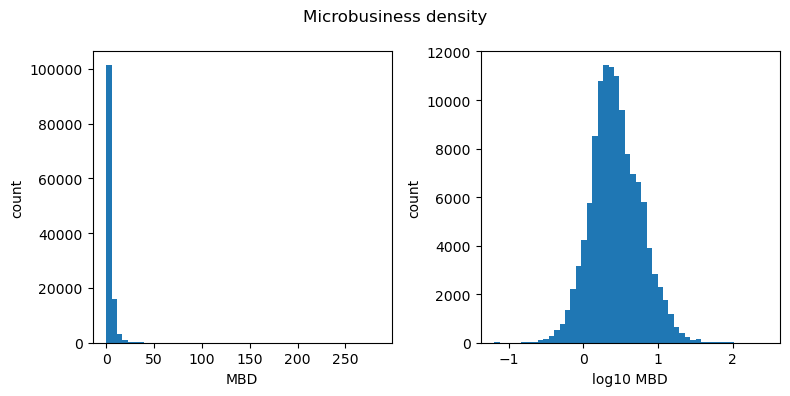

In [9]:
# Get just microbusiness density
microbusiness_density = training_df['microbusiness_density']

# Remove zeros so we can plot the log
microbusiness_density = microbusiness_density[microbusiness_density > 0]

plt = plot_funcs.two_panel_histogram(
    data = microbusiness_density,
    main_title = 'Microbusiness density',
    linear_plot_x_label = 'MBD',
    log10_plot_x_label = 'log10 MBD'
)

plt.show()

Pretty much what we expected - most counties have low microbusiness density, between 0 and ~10, while a few have much higher or lower density, tailing out to over 200 at the high end. Looks log-normal-ish, but shifted up with the mean around 5. This is good news - phenomenon which produce log-normal distributions have been characterized in many domains and the Galton distribution itself is well studied. Log normal distributions are generally produced by the linear combination of positively valued random variables. Mental note for later.

In the plots above, each county is represented by multiple datapoints - one for each timepoint. Let's take a look at the average microbusiness density for each county:

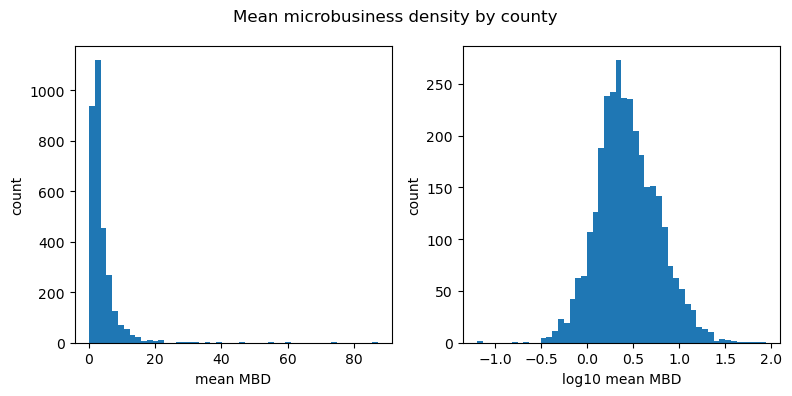

In [10]:
# Get avg microbusiness density by county
avg_microbusiness_density = training_df.groupby('cfips').mean()
avg_microbusiness_density = avg_microbusiness_density['microbusiness_density']

# Remove zeros so we can plot the log
avg_microbusiness_density = avg_microbusiness_density[avg_microbusiness_density > 0]

plt = plot_funcs.two_panel_histogram(
    data = avg_microbusiness_density,
    main_title = 'Mean microbusiness density by county',
    linear_plot_x_label = 'mean MBD',
    log10_plot_x_label = 'log10 mean MBD'
)
plt.show()

Looks similar to the individual timepoint values, but the tail has collapsed a bit. This could indicated that in those strange counties with very high microbusiness density, it either started high and decreased or started lower and increased.

<a name="microbusiness_density_change_distribution"></a>
### 5. Microbusiness density change distribution

Let's take a look at how the microbusiness density is changing within counties over time. Does it increase? decrease? remain static? Some combination of all three? Are there big changes or small changes? What does the distribution of change sizes look like?

In [11]:
# Makes sure the rows are in chronological order within each county
training_df = training_df.sort_values(by=['cfips', 'first_day_of_month'])

# Calculate and add column for month to month change in microbusiness density
training_df['microbusiness_density_change'] = training_df.groupby(['cfips'])['microbusiness_density'].diff() # type: ignore
training_df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,-0.122812
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,0.170973
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,-0.062610
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,0.000000


In [12]:
training_df['microbusiness_density_change'].describe()

count    119130.000000
mean          0.006772
std           1.662071
min        -278.468650
25%          -0.019809
50%           0.000000
75%           0.027311
max         278.459767
Name: microbusiness_density_change, dtype: float64

Huh, so remember what we said about those strange, high microbusiness density counties maybe undergoing large changes over time? Looks like we were right. The maximum and minimum change values are close to the dataset-wide maximum microbusiness density. Maybe some reporting requirements changed in those places causing a bunch of pre-existing microbusinesses to show up in the data all at once? Not sure. Maybe be interesting later on.

Let's plot the individual microbusiness density change value distributions.

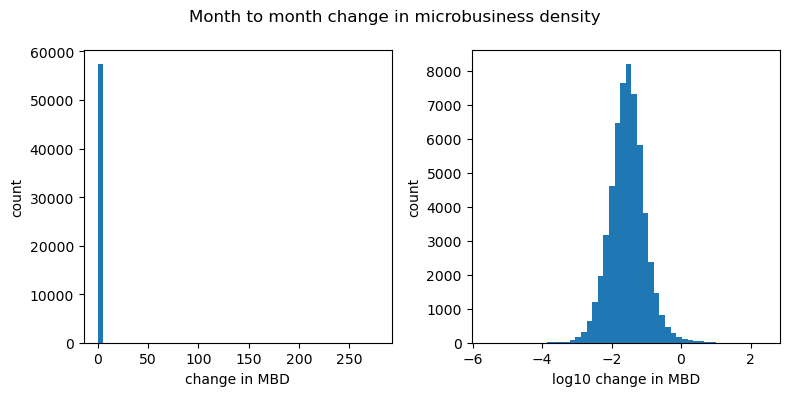

In [13]:
# Get just microbusiness density
microbusiness_density_change = training_df['microbusiness_density_change']

# Remove zeros so we can plot the log
microbusiness_density_change = microbusiness_density_change[microbusiness_density_change > 0]

plt = plot_funcs.two_panel_histogram(
    data = microbusiness_density_change,
    main_title = 'Month to month change in microbusiness density',
    linear_plot_x_label = 'change in MBD',
    log10_plot_x_label = 'log10 change in MBD'
)

plt.show()

OK, so pretty symmetrical but with extreme tails on either side looks like most changes are within +/- 0.2, but we have a small amount of very large increases and decreases. Let's take a look at some of those large changes.

<a name="Extreme_microbusiness_density_change_values"></a>
### 6. Extreme microbusiness density change values

In [14]:
training_df.nlargest(10, columns=['microbusiness_density_change'])

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
94382,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011,278.459767
68658,32510_2021-02-01,32510,Carson City,Nevada,2021-02-01,154.771090,67409,143.311752
122030,56033_2022-10-01,56033,Sheridan County,Wyoming,2022-10-01,227.756650,54509,99.494410
68346,32017_2021-02-01,32017,Lincoln County,Nevada,2021-02-01,72.815079,3091,68.645467
24571,17075_2019-09-01,17075,Iroquois County,Illinois,2019-09-01,45.064705,9994,43.441402
21819,16021_2021-02-01,16021,Boundary County,Idaho,2021-02-01,53.965973,4885,40.775518
122010,56033_2021-02-01,56033,Sheridan County,Wyoming,2021-02-01,80.121498,18992,35.901111
24577,17075_2020-03-01,17075,Iroquois County,Illinois,2020-03-01,38.055630,8373,30.810834
67554,31163_2020-02-01,31163,Sherman County,Nebraska,2020-02-01,26.705250,646,25.671765
93876,46099_2019-11-01,46099,Minnehaha County,South Dakota,2019-11-01,32.935650,45219,23.031429


In [15]:
training_df.nsmallest(10, columns=['microbusiness_density_change'])

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
94383,46127_2019-11-01,46127,Union County,South Dakota,2019-11-01,5.871380,661,-278.468650
94381,46127_2019-09-01,46127,Union County,South Dakota,2019-09-01,5.880263,662,-271.655717
68674,32510_2022-06-01,32510,Carson City,Nevada,2022-06-01,10.847511,4769,-213.690739
12439,12001_2022-09-01,12001,Alachua County,Florida,2022-09-01,7.911023,17398,-38.342860
24576,17075_2020-02-01,17075,Iroquois County,Illinois,2020-02-01,7.244796,1594,-32.924279
119865,55067_2021-02-01,55067,Langlade County,Wisconsin,2021-02-01,2.031179,314,-23.966622
93875,46099_2019-10-01,46099,Minnehaha County,South Dakota,2019-10-01,9.904221,13598,-22.692012
10094,8031_2022-04-01,8031,Denver County,Colorado,2022-04-01,14.552689,83976,-15.163557
13239,12045_2021-02-01,12045,Gulf County,Florida,2021-02-01,4.609603,601,-14.948611
10820,8069_2021-01-01,8069,Larimer County,Colorado,2021-01-01,10.051882,27783,-12.657284


Let's take Union City, South Dakota as an example and see if we can figure out what is going on.

In [16]:
union_county = training_df[training_df['cfips'] == 46127]
union_county.sort_values(by='first_day_of_month', ascending=True).head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
94380,46127_2019-08-01,46127,Union County,South Dakota,2019-08-01,277.535980,31245,NaN
94381,46127_2019-09-01,46127,Union County,South Dakota,2019-09-01,5.880263,662,-271.655717
94382,46127_2019-10-01,46127,Union County,South Dakota,2019-10-01,284.340030,32011,278.459767
94383,46127_2019-11-01,46127,Union County,South Dakota,2019-11-01,5.871380,661,-278.468650
94384,46127_2019-12-01,46127,Union County,South Dakota,2019-12-01,5.862498,660,-0.008883


Yeah, OK - those high values in the first and third timepoints look like some kind of artifact. No way the microbusiness density crashed and then shot back up and then crashed like that in the space of four months. Also, it's pretty stable around the low values for the rest of the timeseries.

Let's look at another one.

In [17]:
carson_city = training_df[training_df['cfips'] == 32510]
carson_city.sort_values(by='first_day_of_month', ascending=True)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
68640,32510_2019-08-01,32510,Carson City,Nevada,2019-08-01,11.617217,5004,NaN
68641,32510_2019-09-01,32510,Carson City,Nevada,2019-09-01,11.357200,4892,-0.260017
68642,32510_2019-10-01,32510,Carson City,Nevada,2019-10-01,11.563821,4981,0.206621
68643,32510_2019-11-01,32510,Carson City,Nevada,2019-11-01,11.352556,4890,-0.211265
68644,32510_2019-12-01,32510,Carson City,Nevada,2019-12-01,11.296838,4866,-0.055718
68645,32510_2020-01-01,32510,Carson City,Nevada,2020-01-01,11.617307,5021,0.320469
68646,32510_2020-02-01,32510,Carson City,Nevada,2020-02-01,11.450717,4949,-0.166590
68647,32510_2020-03-01,32510,Carson City,Nevada,2020-03-01,11.485423,4964,0.034706
68648,32510_2020-04-01,32510,Carson City,Nevada,2020-04-01,11.628876,5026,0.143453
68649,32510_2020-05-01,32510,Carson City,Nevada,2020-05-01,11.557150,4995,-0.071726


OK, this one is a bit more interesting. The microbusiness density starts out around 10 and is fairly stable. It stays that way for more than a year and then in the space of a month shoots up to over 150. The stranger part is - it then stays above 150 for over a year again before crashing back down to around 10. Weird.

That makes me thing there is:
 a. Some artifact in how microbusiness density is being generated (I'm pretty sure GoDaddy is not directly surveying people in these places...)
 b. Some change in the underlying data sources which effects how businesses are being classified etc.

For now, still not sure what to do, but outliers with large microbusiness density and especially large swings in microbusiness density will definitely need some consideration later on.

Let's take a deeper look at the structure of the dataset in terms of the counties and the timeseries.

<a name="dataset_structure"></a>
### 7. Dataset structure

In [18]:
# Get list of counties in the dataset
counties = training_df['county']
counties.drop_duplicates(keep='first', inplace=True)
counties

0            Autauga County
39           Baldwin County
78           Barbour County
117             Bibb County
156           Blount County
                ...        
122031      Sublette County
122070    Sweetwater County
122148         Uinta County
122187      Washakie County
122226        Weston County
Name: county, Length: 1871, dtype: object

In [19]:
# Get list of states in the dataset
states = training_df['state']
states.drop_duplicates(keep='first', inplace=True)
states.head()

0          Alabama
2613        Alaska
3666       Arizona
4251      Arkansas
7176    California
Name: state, dtype: object

Ok, so 1871 counties in the dataset - next question, what is the timeseries range? and is there any missing data? i.e. do all of the counties have the same timepoints?

In [20]:
timepoints = training_df['first_day_of_month']
timepoints.drop_duplicates(keep='first', inplace=True)
timepoints.head()

0   2019-08-01
1   2019-09-01
2   2019-10-01
3   2019-11-01
4   2019-12-01
Name: first_day_of_month, dtype: datetime64[ns]

Total unique timepoints in the dataset is 39. By manual inspection, we have one for each month between August 2019 and October 2022. Now, do we have all 39 rows for each county?

In [21]:
county_counts = training_df.groupby(['county']).size()
county_counts.head()

county
Abbeville County     39
Acadia Parish        39
Accomack County      39
Ada County           39
Adair County        156
dtype: int64

Right off the bat, we have some counties with more than 39 rows of data. Let's split any counties with more or less than 39 rows into two separate lists so that we can take a look and try to figure out what is going on.

In [22]:
high_county_count = county_counts[county_counts > 39]
high_county_count.head()

county
Adair County        156
Adams County        468
Albany County        78
Alexander County     78
Allegany County      78
dtype: int64

Looks like quite a few counties have more than 39. In fact I think I just figured out what is going on. Notice how counties which have more than 39 timepoints always have a number of timepoints which is a multiple of 39? I bet there are no counties with less than 39 timepoints...

In [23]:
low_county_count = county_counts[county_counts < 39]
low_county_count.head()

Series([], dtype: int64)

Yep - pretty sure I know what's going on. We have some county names which appear in multiple states. To confirm, let's look at one county which has more than 39 rows associated with it.

In [24]:
adair_county = training_df[training_df['county'] == 'Adair County']
adair_counties = adair_county['state'].drop_duplicates(keep='first')
print(adair_counties)
adair_county

30693        Iowa
38649    Kentucky
57759    Missouri
82992    Oklahoma
Name: state, dtype: object


,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
30693,19001_2019-08-01,19001,Adair County,Iowa,2019-08-01,2.782208,157,NaN
30694,19001_2019-09-01,19001,Adair County,Iowa,2019-09-01,2.746766,155,-0.035442
30695,19001_2019-10-01,19001,Adair County,Iowa,2019-10-01,2.782208,157,0.035442
30696,19001_2019-11-01,19001,Adair County,Iowa,2019-11-01,2.870813,162,0.088605
30697,19001_2019-12-01,19001,Adair County,Iowa,2019-12-01,2.853092,161,-0.017721
...,...,...,...,...,...,...,...,...
83026,40001_2022-06-01,40001,Adair County,Oklahoma,2022-06-01,0.975008,158,-0.012342
83027,40001_2022-07-01,40001,Adair County,Oklahoma,2022-07-01,0.968837,157,-0.006171
83028,40001_2022-08-01,40001,Adair County,Oklahoma,2022-08-01,0.968837,157,0.000000
83029,40001_2022-09-01,40001,Adair County,Oklahoma,2022-09-01,0.981179,159,0.012342


Yep, we have 4 Adair counties in Iowa, Kentucky, Missouri and Oklahoma. We counted 156 rows for Adair County and 4 x 39 = 156, so I think we solved it. We will have to be sure and use the cfips ID number to group by county in the future like so:

In [25]:
county_counts = training_df.groupby(['cfips']).size()
abnormal_county_count = county_counts[county_counts != 39]

print(f'Number of counties: {len(county_counts)}')
print(f'Counties with incorrect row count: {len(abnormal_county_count)}')

Number of counties: 3135
Counties with incorrect row count: 0


OK, great. No missing timepoints and we have quite a few more counties than we thought.

Next I want to visually inspect some of the data as a timeseries to get a feel for what it looks like.

<a name="microbusiness_density_timeseries_plots"></a>
### 8. Microbusiness density timeseries plots

First, let's just pick one county and take a look at it as an example.

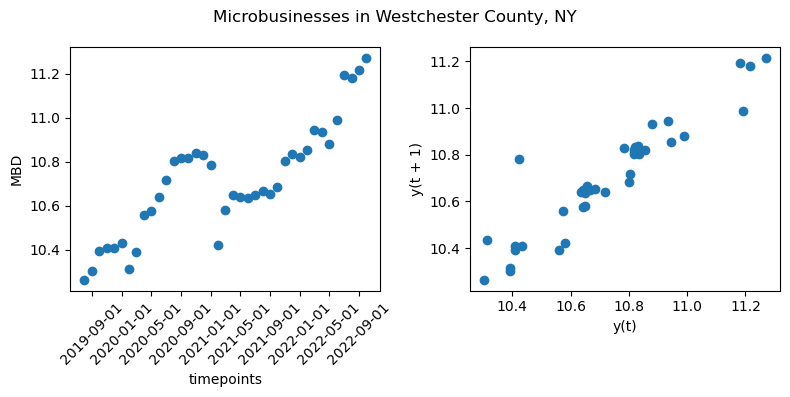

In [26]:
westchester_NY_cfips = 36119
westchester_NY = training_df[training_df['cfips'] == westchester_NY_cfips]

plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = westchester_NY['first_day_of_month'],
    timeseries_y_data = westchester_NY['microbusiness_density'],
    main_title = 'Microbusinesses in Westchester County, NY',
    timeseries_y_label = 'MBD',
)

plt.show()

Ok, looks good?... generally increasing but jumps around quite a bit. Lag plot also looks like a generally positive autocorrelation over time with some outliers. We could dream up all kinds of data engineering tricks here: smoothing, flattening, windowing etc. Let's leave it alone for now. I'd like to see the lag plot for the whole dataset. Let's see if we can make that now:

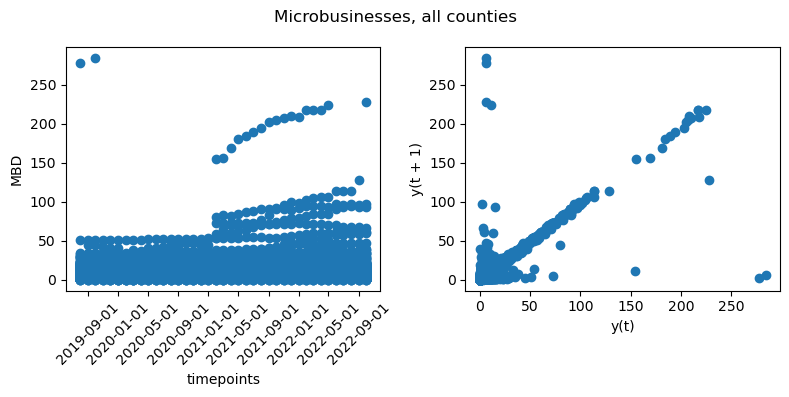

In [27]:
plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = training_df['first_day_of_month'],
    timeseries_y_data = training_df['microbusiness_density'],
    main_title = 'Microbusinesses, all counties',
    timeseries_y_label = 'MBD',
)

plt.show()

OK, so dataset wide lag plot looks about like I expected, lots of positive autocorrelation month to month with a bunch of other stuff going on at low MBDs and some outliers. The big thing that jumps out here though is the timeseries plot of the individual counties. It has an interesting feature - look at the jump around January or February 2021. It's a little hard to see bu there are clearly some counties appear to experience a big step up all at the same time.

To get a better look at the data I think we should try standardizing it within counties. This will make the changes jump out more since we have such widely varying underlying magnitudes in each county.

<a name="investigate_feb_2021_discontinuity"></a>
### 9. Investigate Feb. 2021 discontinuity

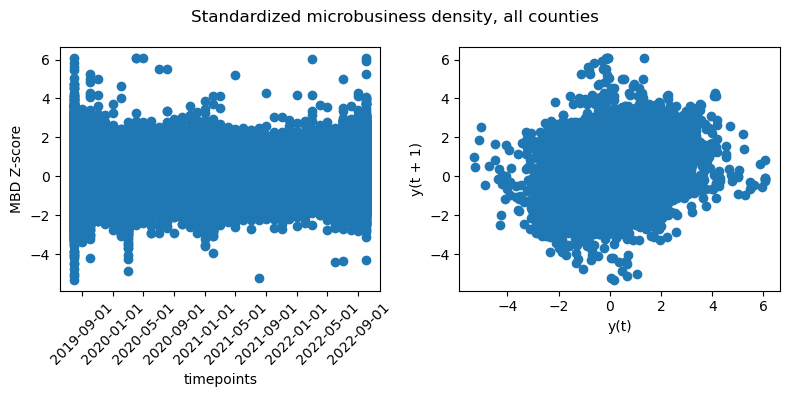

In [28]:
zscore = lambda x: (x - x.mean()) / x.std()

if 'microbusiness_density_Z' not in list(training_df.columns):
    training_df.insert(1, 'microbusiness_density_Z', training_df.groupby(['cfips'])['microbusiness_density'].transform(zscore))

plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = training_df['first_day_of_month'],
    timeseries_y_data = training_df['microbusiness_density_Z'],
    main_title = 'Standardized microbusiness density, all counties',
    timeseries_y_label = 'MBD Z-score',
)

plt.show()

Hmm, ok - interesting, so standardizing didn't make the February 2021 discontinuity pop out the way I thought maybe it might. It is good to know that in aggregate the counties don't appear to be overall increasing or decreasing. We probably have some of both. Also, standardizing converts the lag plot into a blob. That suggests that the variability in MDB doesn't scale with the mean value, i.e. counties with large numbers of microbusinesses experience similar size changes in MDB as counties with smaller numbers. This could be responsible for producing the y(t) = y(t + 1) observed in the unstandardized lag plot. 

I am still interested in the jump observed on the unstandardized timeseries plot. It looks like it might scale with the underlying average microbusiness density of the county. Counties with higher microbusiness density look like they might have a larger jump. Is this true? Do they all have it to some extent? or just the top few?

Let's grab the top few counties by average microbusiness density and plot just those.

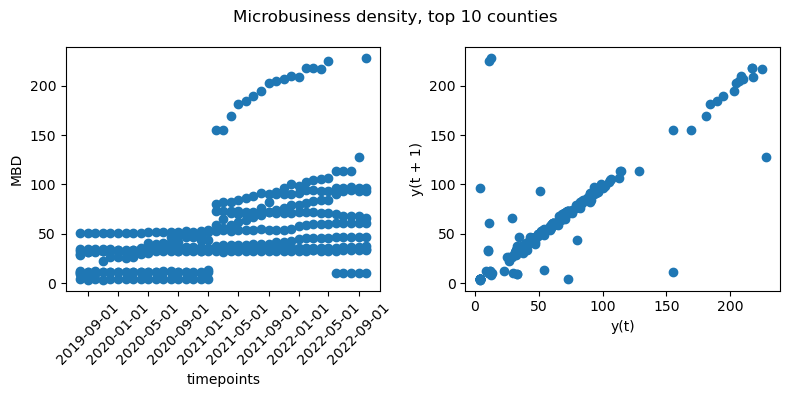

In [29]:
if 'avg_microbusiness_density' not in list(training_df.columns):
    training_df.insert(1, 'avg_microbusiness_density', training_df.groupby(['cfips'])['microbusiness_density'].transform('mean'))

# 39 timepoints per county so 390 rows should be the full timecourse for the top 10 highest
# MBD counties
high_avg_microbusiness_density = training_df.nlargest(390, columns=['avg_microbusiness_density'])

plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = high_avg_microbusiness_density['first_day_of_month'],
    timeseries_y_data = high_avg_microbusiness_density['microbusiness_density'],
    main_title = 'Microbusiness density, top 10 counties',
    timeseries_y_label = 'MBD',
)

plt.show()

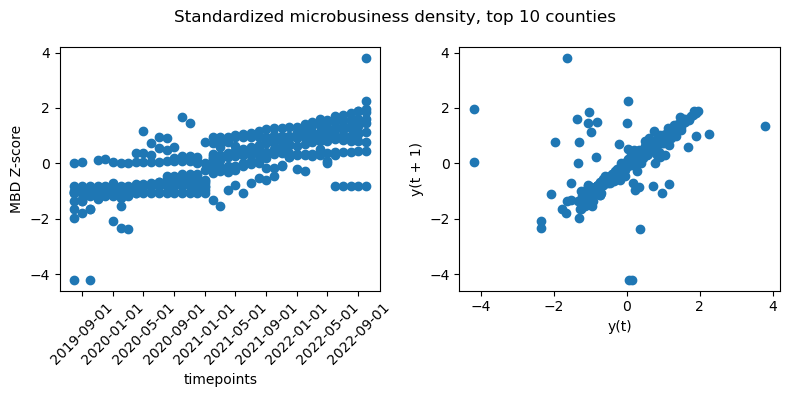

In [30]:
plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = high_avg_microbusiness_density['first_day_of_month'],
    timeseries_y_data = high_avg_microbusiness_density['microbusiness_density_Z'],
    main_title = 'Standardized microbusiness density, top 10 counties',
    timeseries_y_label = 'MBD Z-score',
)

plt.show()

Yep, now we can see it clear as day - MBD looks like a step function for most of these counties, if not all. Also nice to see the linear looking lag plot come back when plotting standardized values for only high mean MDB counties. Means our earlier explanation was probably on the right track.

Let's try plotting the change in MDB and we should see also a spike in February 2021.

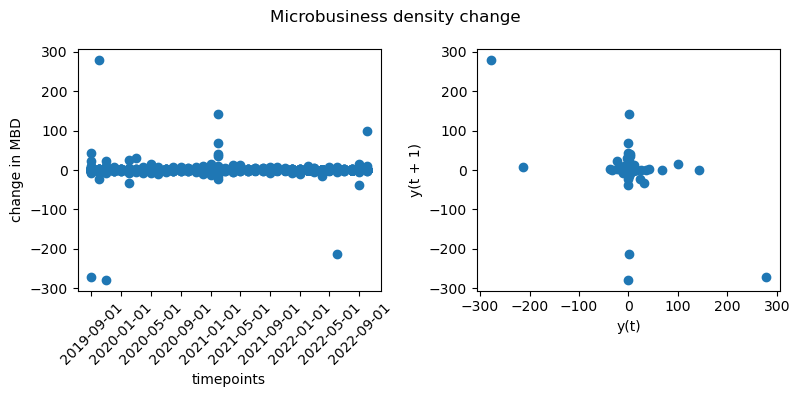

In [31]:
plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = training_df['first_day_of_month'],
    timeseries_y_data = training_df['microbusiness_density_change'],
    main_title = 'Microbusiness density change',
    timeseries_y_label = 'change in MBD',
)

Still not exactly jumping out the way I think it could - maybe let's try standardizing the change within counties...

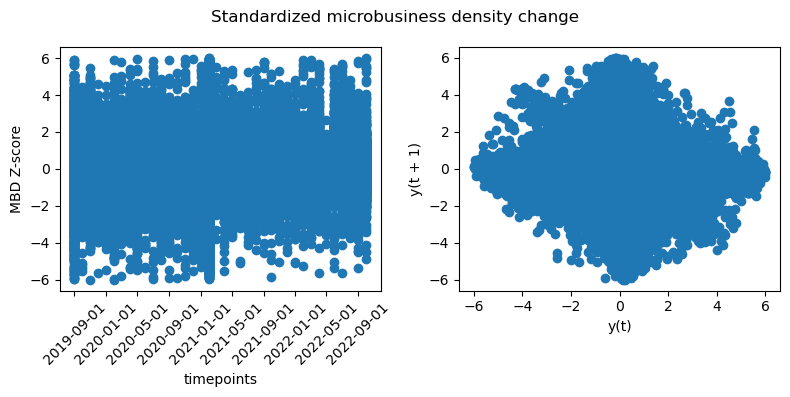

In [32]:
if 'microbusiness_density_change_Z' not in list(training_df.columns):
    training_df.insert(1, 'microbusiness_density_change_Z', training_df.groupby(['cfips'])['microbusiness_density_change'].transform(zscore))

plt = plot_funcs.timeseries_lag_two_panel_plot(
    timeseries_x_data = training_df['first_day_of_month'],
    timeseries_y_data = training_df['microbusiness_density_change_Z'],
    main_title = 'Standardized microbusiness density change',
    timeseries_y_label = 'MBD Z-score',
)

Still not quite satisfied with this. Maybe I'm making a mountain out of a mole hill and we shouldn't obsess over this right now. But my gut tells me it's important. Let's see if we can figure out how many and which counties had a larger than expected change in or around February 2021. Then maybe we can think about what those counties have in common. Are they near each other geographically? I dunno - hopefully something jumps out. At least we will have a 'watch' list for this specific bit of data weirdness.

<a name="date_of_max_microbusiness_change_per_county"></a>
### 10. Date of max microbusiness density change per county

In [33]:
max_change_df = training_df.sort_values('microbusiness_density_change', ascending=False).groupby('cfips').first()
february_discontinuity = max_change_df[max_change_df['first_day_of_month'] == '2021-02-01']
february_discontinuity = february_discontinuity.sort_values('microbusiness_density_change', ascending=False)
print(f'Number of counties with max change occurring in February 2021: {len(february_discontinuity)}')
february_discontinuity.head()

Number of counties with max change occurring in February 2021: 611


,row_id,microbusiness_density_change_Z,avg_microbusiness_density,microbusiness_density_Z,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
cfips,,,,,,,,,,
32510,32510_2021-02-01,3.372547,87.196625,0.726228,Carson City,Nevada,2021-02-01,154.771090,67409,143.311752
32017,32017_2021-02-01,5.995468,40.140351,0.963290,Lincoln County,Nevada,2021-02-01,72.815079,3091,68.645467
16021,16021_2021-02-01,5.864756,46.730638,0.209616,Boundary County,Idaho,2021-02-01,53.965973,4885,40.775518
10005,10005_2021-02-01,3.809929,30.527487,-0.444752,Sussex County,Delaware,2021-02-01,22.800505,41522,9.208170
21215,21215_2021-02-01,5.877438,7.147836,0.855492,Spencer County,Kentucky,2021-02-01,11.087939,1595,8.863399


In [34]:
max_changes_per_month = max_change_df['first_day_of_month'].value_counts()
max_changes_per_month_df = pd.DataFrame({'first_day_of_month':max_changes_per_month.index, 'county_max_change_count':max_changes_per_month.values})
max_changes_per_month_df = max_changes_per_month_df.sort_values('first_day_of_month')
max_changes_per_month_df.reset_index(inplace=True, drop=True)
max_changes_per_month_df.head()

,first_day_of_month,county_max_change_count
0,2019-09-01,305
1,2019-10-01,77
2,2019-11-01,125
3,2019-12-01,30
4,2020-01-01,42


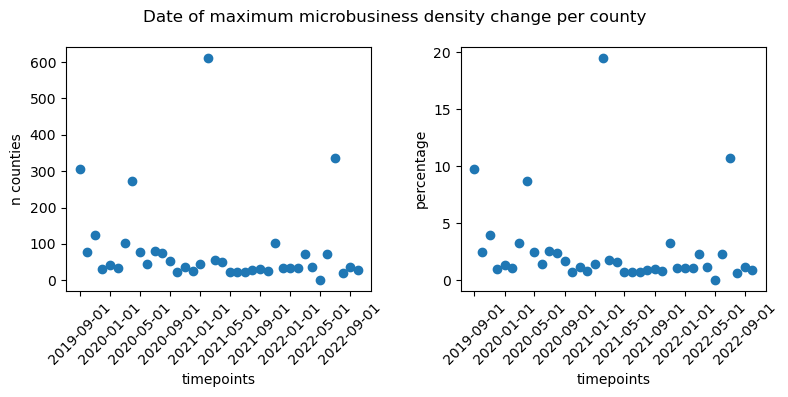

In [35]:
plt = plot_funcs.timeseries_percentage_two_panel_plot(
    timeseries_x_data = max_changes_per_month_df['first_day_of_month'],
    timeseries_y_data = max_changes_per_month_df['county_max_change_count'],
    main_title = 'Date of maximum microbusiness density change per county',
    timeseries_y_label = 'n counties',
)

OK, so about ~20% or ~600 counties have their max change in microbusiness density February 2021. It also could be more extreme than that. The above numbers are derived from the max change only. What if we instead looked at the top 3 or 5 months with the most change? How many more counties would tick Feb. 2021.

Before that, what counties are these? What states are they in? Are they near each other?

In [36]:
state_counts = february_discontinuity.groupby(['state']).size()
print(f'Number of states with February discontinuity: {len(state_counts)}')
state_counts.head()

Number of states with February discontinuity: 48


state
Alabama       17
Alaska         2
Arizona        3
Arkansas      14
California     7
dtype: int64

OK, so no real insight here - looks like we caught almost all of the states. The number 48 looks like the contiguous states, but it's not - I see Alaska and Hawaii in the list. Maybe counties with the discontinuity are over represented in some states over others. To answer that question we would need to normalize by the number of counties present in the data set for each state. Regardless, it's clear that the discontinuity is not due to some new state law or other highly localized event.

In [37]:
top_change_df = training_df.sort_values('microbusiness_density_change', ascending=False).groupby('cfips').head(4)
top_change_df.head()

,row_id,microbusiness_density_change_Z,avg_microbusiness_density,microbusiness_density_Z,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
94382,46127_2019-10-01,3.646969,19.630615,4.300569,46127,Union County,South Dakota,2019-10-01,284.340030,32011,278.459767
68658,32510_2021-02-01,3.372547,87.196625,0.726228,32510,Carson City,Nevada,2021-02-01,154.771090,67409,143.311752
122030,56033_2022-10-01,5.569690,73.510410,3.799309,56033,Sheridan County,Wyoming,2022-10-01,227.756650,54509,99.494410
68346,32017_2021-02-01,5.995468,40.140351,0.963290,32017,Lincoln County,Nevada,2021-02-01,72.815079,3091,68.645467
24571,17075_2019-09-01,4.147507,12.454105,2.102689,17075,Iroquois County,Illinois,2019-09-01,45.064705,9994,43.441402


In [38]:
september_discontinuity = top_change_df[top_change_df['first_day_of_month'] == '2021-02-01']
september_discontinuity = september_discontinuity.sort_values('microbusiness_density_change', ascending=False)
print(f'Number of counties with a top 10% change occurring in February 2021: {len(september_discontinuity)}')
september_discontinuity.head()

Number of counties with a top 10% change occurring in February 2021: 971


,row_id,microbusiness_density_change_Z,avg_microbusiness_density,microbusiness_density_Z,cfips,county,state,first_day_of_month,microbusiness_density,active,microbusiness_density_change
68658,32510_2021-02-01,3.372547,87.196625,0.726228,32510,Carson City,Nevada,2021-02-01,154.771090,67409,143.311752
68346,32017_2021-02-01,5.995468,40.140351,0.963290,32017,Lincoln County,Nevada,2021-02-01,72.815079,3091,68.645467
21819,16021_2021-02-01,5.864756,46.730638,0.209616,16021,Boundary County,Idaho,2021-02-01,53.965973,4885,40.775518
122010,56033_2021-02-01,1.813451,73.510410,0.162841,56033,Sheridan County,Wyoming,2021-02-01,80.121498,18992,35.901111
12342,10005_2021-02-01,3.809929,30.527487,-0.444752,10005,Sussex County,Delaware,2021-02-01,22.800505,41522,9.208170


In [39]:
top_changes_per_month = top_change_df['first_day_of_month'].value_counts()
top_changes_per_month_df = pd.DataFrame({'first_day_of_month':top_changes_per_month.index, 'county_top_change_count':top_changes_per_month.values})
top_changes_per_month_df = top_changes_per_month_df.sort_values('first_day_of_month')
top_changes_per_month_df.reset_index(inplace=True, drop=True)
top_changes_per_month_df['county_top_change_percent'] = (top_changes_per_month_df['county_top_change_count'] / top_changes_per_month_df['county_top_change_count'].sum()) * 100
top_changes_per_month_df.head()

,first_day_of_month,county_top_change_count,county_top_change_percent
0,2019-09-01,787,6.275917
1,2019-10-01,272,2.169059
2,2019-11-01,571,4.553429
3,2019-12-01,125,0.996810
4,2020-01-01,225,1.794258


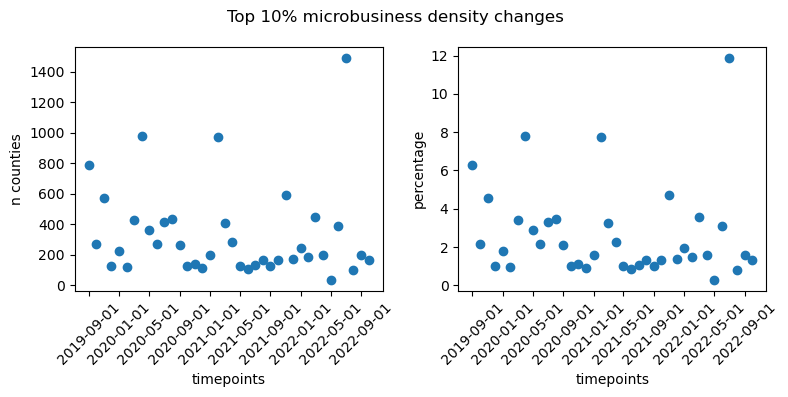

In [40]:
plt = plot_funcs.timeseries_percentage_two_panel_plot(
    timeseries_x_data = top_changes_per_month_df['first_day_of_month'],
    timeseries_y_data = top_changes_per_month_df['county_top_change_count'],
    main_title = 'Top 10% microbusiness density changes',
    timeseries_y_label = 'n counties',
)

Stranger and stranger - plotting when the top 4 (~10%) largest changes occurred for each county still pings February 2021 but it also calls out another hot date in spring 2022. Not sure what to do about any of this. Think we might just have to move on with the knowledge that we have some outliers in terms of dates where lots of change happens dataset-wide.

<a name="microbusiness_density_trends"></a>
### 11. Microbusiness density trends per county

Now I want to answer the question we asked earlier - how is microbusiness density changing in counties. Increasing? Decreasing? By how much? Some of both? Let's see. We know from our distribution plots that the mean change for counties over the time range is slightly positive at ~0.007 with a standard deviation of ~1.7. Positive and negative mean change values are present as well as zeros. Let's try a quick linear fit to each counties timeseries and take a look at the slop and R^2 values.

In [41]:
if 'timepoint_num' not in list(training_df.columns):
    training_df.insert(1, 'timepoint_num' ,training_df.groupby(['cfips']).cumcount())

In [42]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = sm.add_constant(data[xvars])
    result = sm.OLS(Y, X).fit()

    return result.params[1], result.rsquared, result.pvalues[1]

result = training_df.groupby('cfips').apply(regress, 'microbusiness_density', ['timepoint_num']) # type: ignore

result_df = result.apply(pd.Series)
result_df.columns = ['coefficient', 'R-squared', 'p-value']
result_df.reset_index(inplace=True, drop=False)
result_df.head()
result_stats_df = result_df.describe()

coeffs_percentiles = [
    result_stats_df.loc['25%','coefficient'], 
    result_stats_df.loc['50%', 'coefficient'], 
    result_stats_df.loc['75%', 'coefficient']
]

rsquared_percentiles = [
    result_stats_df.loc['25%','R-squared'], 
    result_stats_df.loc['50%', 'R-squared'], 
    result_stats_df.loc['75%', 'R-squared']
]

result_stats_df

,cfips,coefficient,R-squared,p-value
count,3135.000000,3135.000000,3.135000e+03,3.135000e+03
mean,30376.037640,0.008262,4.545434e-01,7.577586e-02
std,15145.862593,0.138871,2.958641e-01,1.964694e-01
min,1001.000000,-2.011930,6.925080e-09,5.113009e-38
25%,18178.000000,-0.004504,1.733342e-01,9.579553e-12
50%,29173.000000,0.002285,4.767968e-01,1.147215e-06
75%,45076.000000,0.009685,7.190697e-01,8.381457e-03
max,56045.000000,4.179689,9.892360e-01,9.995988e-01


/home/siderealyear/anaconda3/envs/microbusiness/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


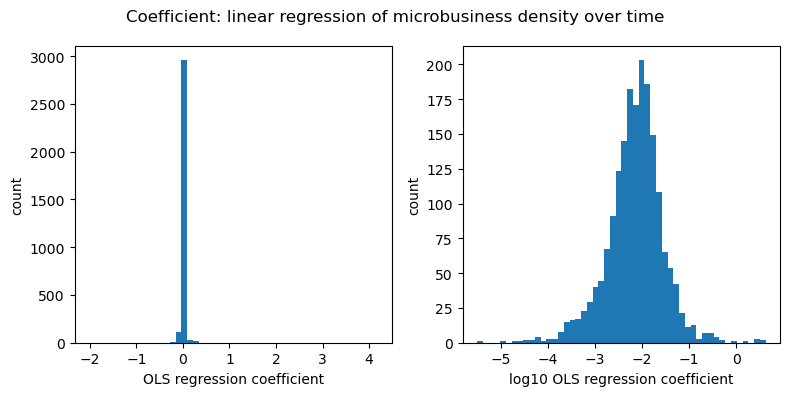

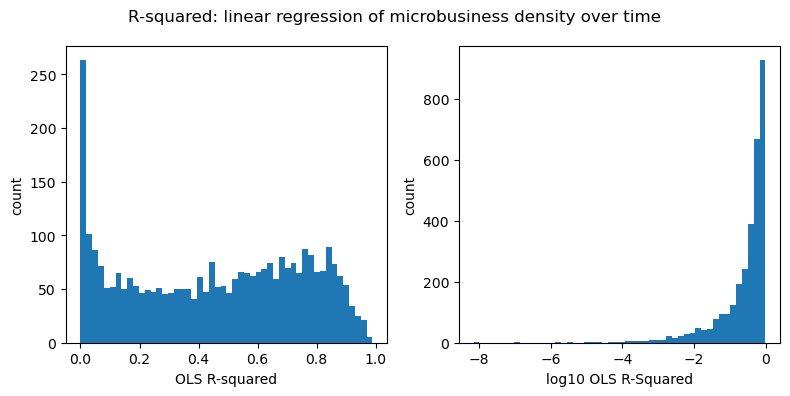

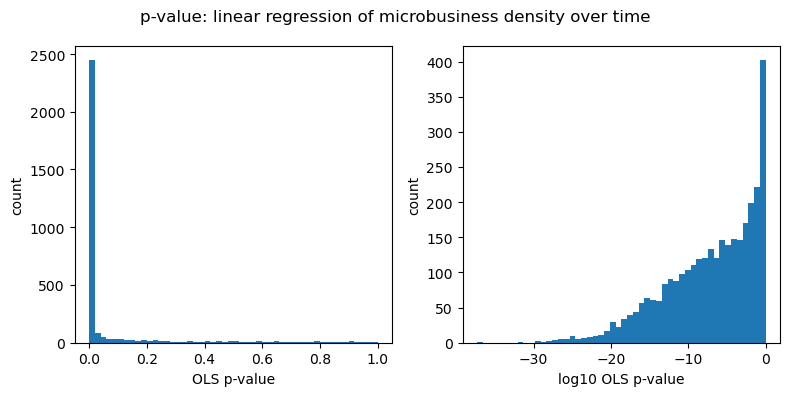

In [43]:
plt = plot_funcs.two_panel_histogram(
    data = result_df['coefficient'],
    main_title = 'Coefficient: linear regression of microbusiness density over time',
    linear_plot_x_label = 'OLS regression coefficient',
    log10_plot_x_label = 'log10 OLS regression coefficient'
)

plt.show()

plt = plot_funcs.two_panel_histogram(
    data = result_df['R-squared'],
    main_title = 'R-squared: linear regression of microbusiness density over time',
    linear_plot_x_label = 'OLS R-squared',
    log10_plot_x_label = 'log10 OLS R-Squared'
)

plt.show()

plt = plot_funcs.two_panel_histogram(
    data = result_df['p-value'],
    main_title = 'p-value: linear regression of microbusiness density over time',
    linear_plot_x_label = 'OLS p-value',
    log10_plot_x_label = 'log10 OLS p-value'
)

plt.show()

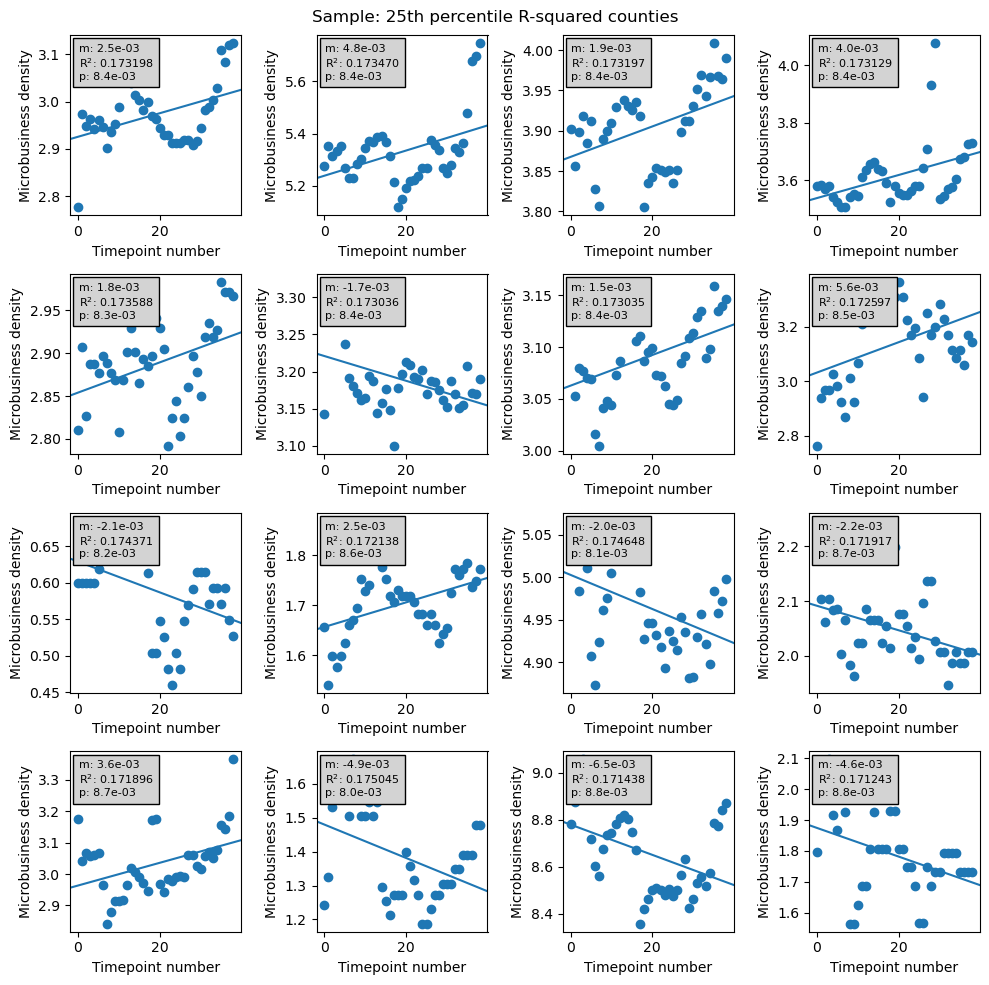

In [44]:
small_R_cfips = result_df.iloc[(result_df['R-squared'] - rsquared_percentiles[0]).abs().argsort()[:16]]['cfips'].to_list()

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    cfips_list = small_R_cfips,
    rows = 4,
    columns = 4,
    main_title = 'Sample: 25th percentile R-squared counties'
)

plt.show()

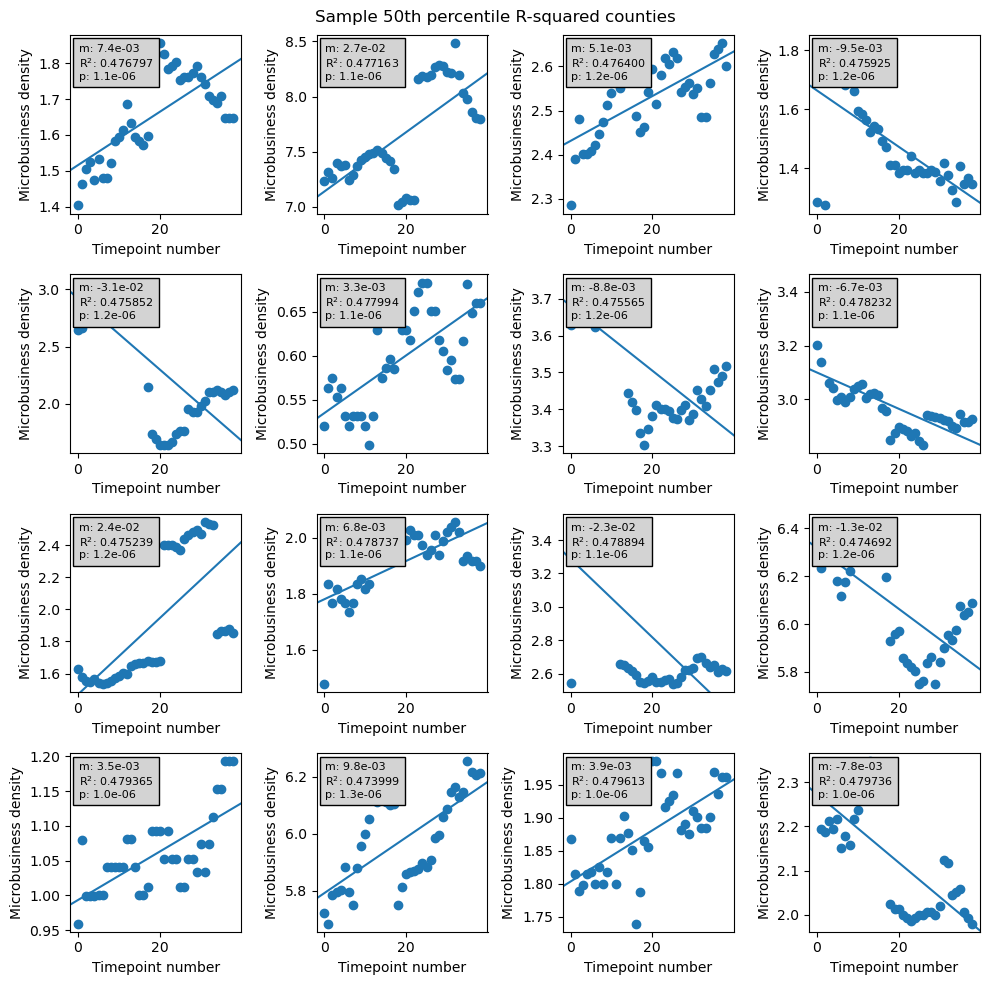

In [45]:
avg_R_cfips = result_df.iloc[(result_df['R-squared'] - rsquared_percentiles[1]).abs().argsort()[:16]]['cfips'].to_list()

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    cfips_list = avg_R_cfips,
    rows = 4,
    columns = 4,
    main_title = 'Sample 50th percentile R-squared counties'
)

plt.show()

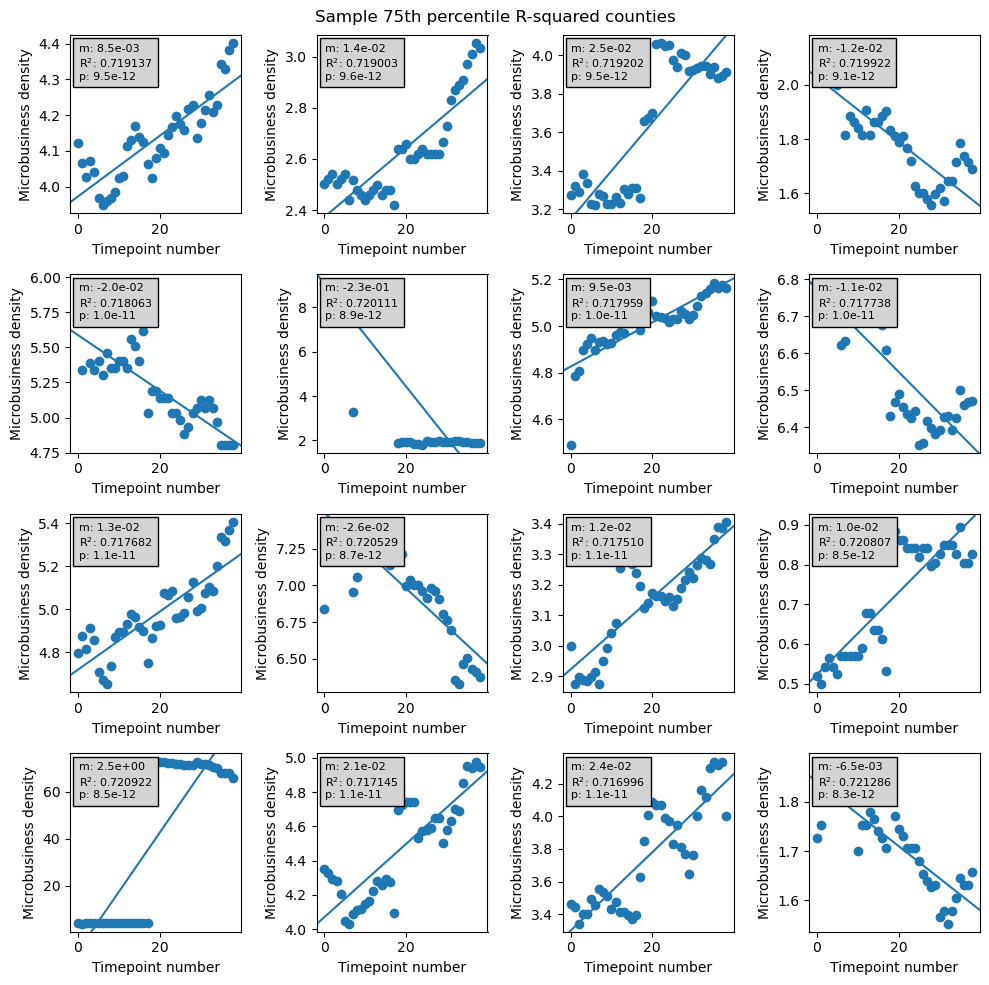

In [46]:
large_R_cfips = result_df.iloc[(result_df['R-squared'] - rsquared_percentiles[2]).abs().argsort()[:16]]['cfips'].to_list()

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    cfips_list = large_R_cfips,
    rows = 4,
    columns = 4,
    main_title = 'Sample 75th percentile R-squared counties'
)

plt.show()

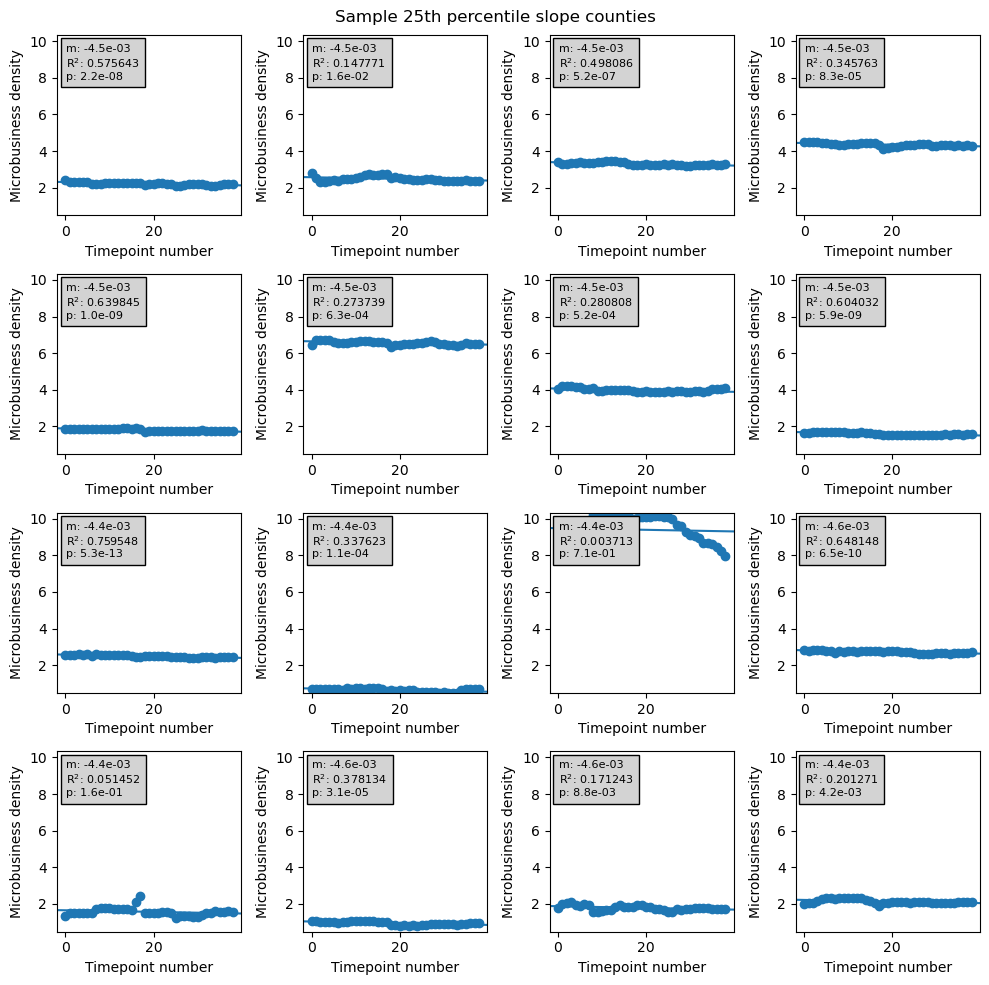

In [47]:
small_coeff_cfips = result_df.iloc[(result_df['coefficient'] - coeffs_percentiles[0]).abs().argsort()[:16]]['cfips'].to_list()

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    cfips_list = small_coeff_cfips,
    rows = 4,
    columns = 4,
    main_title = 'Sample 25th percentile slope counties',
    set_const_ylims = True
)

plt.show()

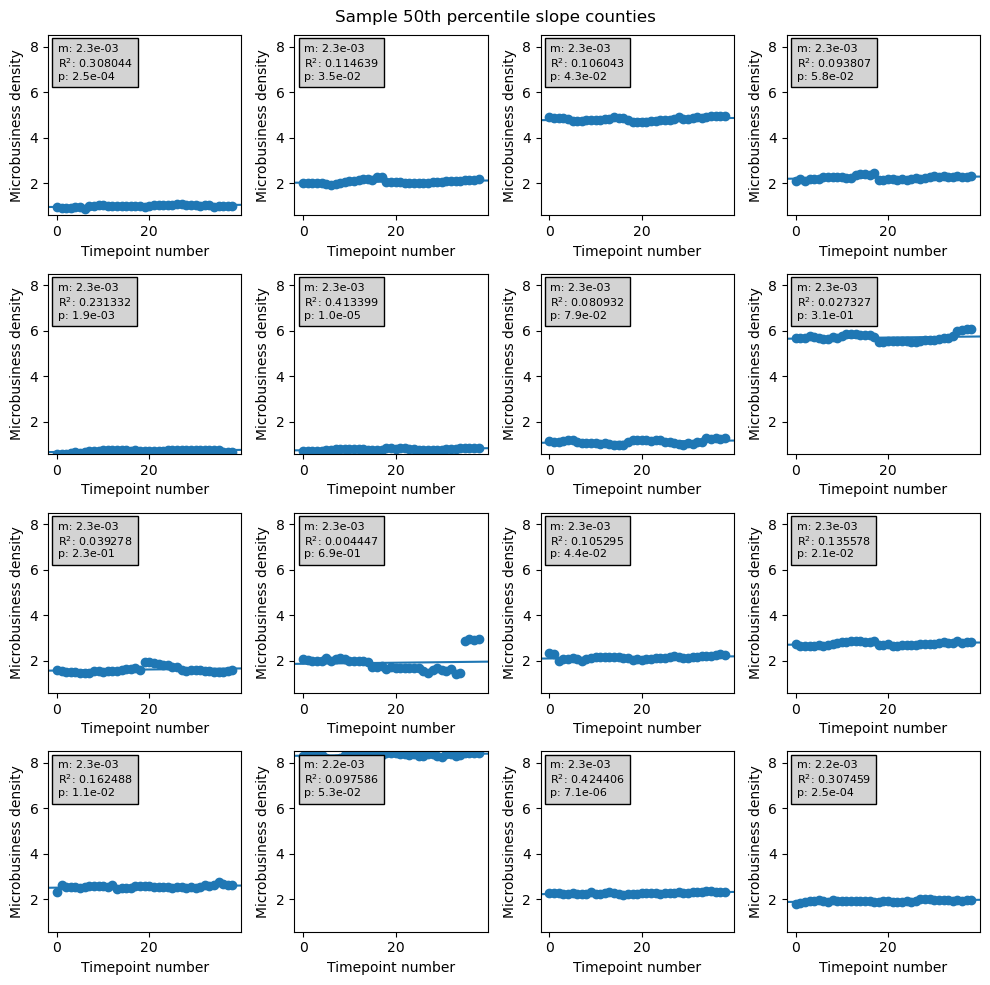

In [48]:
avg_coeff_cfips = result_df.iloc[(result_df['coefficient'] - coeffs_percentiles[1]).abs().argsort()[:16]]['cfips'].to_list()

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    cfips_list = avg_coeff_cfips,
    rows = 4,
    columns = 4,
    main_title = 'Sample 50th percentile slope counties',
    set_const_ylims = True
)

plt.show()

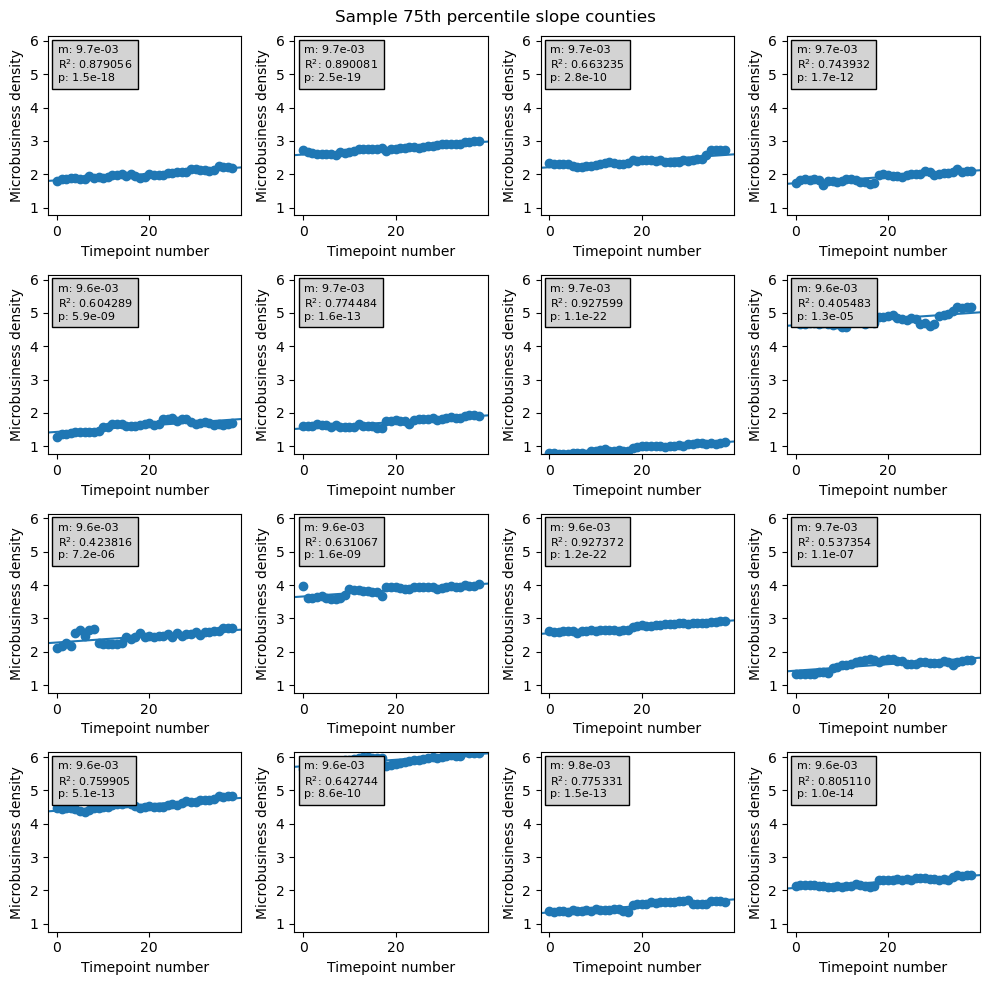

In [49]:
large_coeff_cfips = result_df.iloc[(result_df['coefficient'] - coeffs_percentiles[2]).abs().argsort()[:16]]['cfips'].to_list()

plt = plot_funcs.n_by_n_regression_plot(
    input_data = training_df,
    cfips_list = large_coeff_cfips,
    rows = 4,
    columns = 4,
    main_title = 'Sample 75th percentile slope counties',
    set_const_ylims = True
)

plt.show()

Let's come up with a little summary of what we have learned.

<a name="TLDR"></a>
### 11. TLDR

##### Dataset structure
1. All 50 states are represented, along with the District of Columbia.
2. 3135 counties, unique by 'cfips'.
3. Each county has 39 monthly timepoints: 2019-08-01 to 2022-10-01.
4. No missing rows or NAs in microbusiness density.

##### Qualitative observations5. Move on to test data exploration.
1. Microbusiness density has very few zeros. These occur in counties where either all microbusinesses closed or the first opened during the dataset's time range.
2. Microbusiness density is log10-normal-ish with small, long tails.
3. Some high microbusiness density outliers are present which cannot easily be explained.
4. High microbusiness density outliers seem to mostly come from unrealistically large and fast changes in microbusiness density (e.g. >10x increase in 1 month).
5. Some specific dates are over represented in abnormally large changes in microbusiness density (e.g. ~20% of counties experienced their largest recorded change in microbusiness density on 2021-02-01).
6. Other scattered, large discontinuities are present in many counties.
7. Weirdness in points 5 & 6 is not explained by county location - change values which produce 'hot dates' come from counties in almost all states.

<a name="TODO"></a>
### 12. TODO
1. <s>Fix plot labels/titles.</s>
2. <s>How does microbusiness density change in counties: increase, decrease, stay the same, fluctuate randomly? Some of each? In what proportions.</s>
3. Define and replace 'microbusiness density' with *MBD*?
4. <s>Refactor two panel plot definitions.</s>
5. Look at dependence of microbusiness change magnitude on absolute number of microbusinesses in counties.
6. Move on to test data exploration.